# Lab 03: Runtime Complexity

In [65]:
# remember to evaluate this cell first!
import matplotlib.pylab as plt
import numpy as np
import math
import timeit
import random
import time
%matplotlib inline

## Overview

In this lab you will be given a number of pre-written functions and, for each function $f$, will:

1. Determine its asymptotic runtime complexity; i.e., find $g$ where $f=O(g)$
2. Evaluate and collect runtimes of $f$ over different sizes of input
3. Plot collected runtimes along with appropriately parameterized graphs of $g$ to demonstrate tight asymptotic bounds

It is possible that in step 3 you will realize the bounding function $g$ you settled on in step 1 was incorrect, in which case you will need to make adjustments.

The next two sections cover how to create basic plots with `matplotlib` and use `timeit` to collect timing data. We did both of these in the timing lecture, but a recap might be helpful!

## Plotting with matplotlib

You can use the matplotlib library to create all sorts of sophisticated visualizations, but we will use it solely for drawing simple 2-dimensional plots. You can check out the [project website](https://matplotlib.org) for documentation on other features.

The plotting function we will use is `matplotlib.pyplot.plot` ([full documentation here](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot)), which, when passed two "array-like" objects of equal length, will interpret and plot their contents as x and y axis coordinates. We will generally use tuples, lists, and ranges as array-like objects. Note that generators are *not* considered array-like by matplotlib.

Some examples (note that we use a semicolon after the call to `plot` to hide its return value):

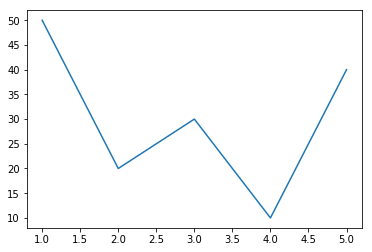

In [66]:
plt.plot([1, 2, 3, 4, 5], [50, 20, 30, 10, 40]);

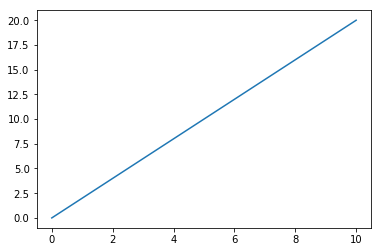

In [67]:
xs = range(11)
ys = [x*2 for x in xs]
plt.plot(xs, ys);

We can also provide an optional format string to `plot`, which controls marker, line-style, and color for the plot.

Here's a shortened list of options copied from the [full documentation of `plot`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot):

**Markers**

  - `.` : point marker
  - `o` : circle marker
  - `s` : square marker
  - `d` : diamond marker

**Line-styles**
 
  - `-` : solid line style
  - `--` : dashed line style
  - `:` : dotted line style

**Colors**

  - `k` : black
  - `r` : red
  - `g` : blue
  - `b` : green
  - `y` : yellow
  - `c` : cyan
  
Here are the above plots with some color and styling (if we omit a line style no connecting line is drawn between data points):

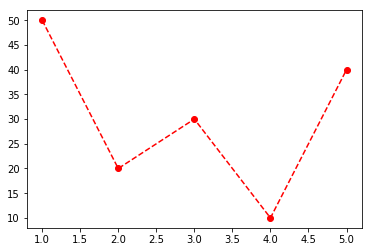

In [68]:
plt.plot([1, 2, 3, 4, 5], [50, 20, 30, 10, 40], 'o--r');

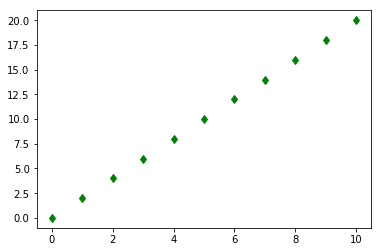

In [69]:
xs = range(11)
ys = [x*2 for x in xs]
plt.plot(xs, ys, 'dg');

Instead of regular `range` objects, which only allow for integral start/stop/step values, we typically prefer to use the [numpy library](https://numpy.org)'s `arange` and `linspace` functions with matplotlib. `arange` is like `range`, except we can use floating point values for start/stop/step. `linspace` lets us specify start and stop values (both inclusive), and the number of values to return in that interval.

Examples of `arange` and `linspace` calls (note that both functions return numpy arrays, which are iterable and can be passed to `plot`):

In [70]:
np.arange(0.5, 2.5, 0.1)

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4])

In [71]:
np.linspace(10, 20, 41)

array([10.  , 10.25, 10.5 , 10.75, 11.  , 11.25, 11.5 , 11.75, 12.  ,
       12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 , 13.75, 14.  , 14.25,
       14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75, 16.  , 16.25, 16.5 ,
       16.75, 17.  , 17.25, 17.5 , 17.75, 18.  , 18.25, 18.5 , 18.75,
       19.  , 19.25, 19.5 , 19.75, 20.  ])

In [72]:
np.linspace(1, 100_000, 50, dtype=int) # we can specify the data type to coerce values into integers

array([     1,   2041,   4082,   6123,   8164,  10204,  12245,  14286,
        16327,  18368,  20408,  22449,  24490,  26531,  28572,  30612,
        32653,  34694,  36735,  38776,  40816,  42857,  44898,  46939,
        48980,  51020,  53061,  55102,  57143,  59184,  61224,  63265,
        65306,  67347,  69388,  71428,  73469,  75510,  77551,  79592,
        81632,  83673,  85714,  87755,  89796,  91836,  93877,  95918,
        97959, 100000])

`plot` can be called multiple times in the same cell to draw multiple lines in the same chart. Below we use this facility together with `linspace` and a handful of list comprehensions to plot some common runtime complexity bounding functions over a small interval: 

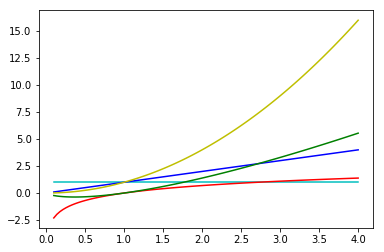

In [73]:
count = 100
xs = np.linspace(0.1, 4, count)
ys_const        = [1] * count
ys_log          = [math.log(x) for x in xs]
ys_linear       = [x for x in xs]
ys_linearithmic = [x * math.log(x) for x in xs]
ys_quadratic    = [x**2 for x in xs]

plt.plot(xs, ys_const, 'c')
plt.plot(xs, ys_log, 'r')
plt.plot(xs, ys_linear, 'b')
plt.plot(xs, ys_linearithmic, 'g')
plt.plot(xs, ys_quadratic, 'y');

## Collecting timings with timeit

The timeit module contains the `timeit` function which measures the runtime of code that we pass to it. As covered in class, `timeit` has the following API:

    timeit(stmt='pass', setup='pass', number=1000000, globals=None)

In a typical invocation, we would pass it code in `stmt` that calls a function defined in our notebook, code in `setup` that initializes any arguments used by `stmt`, a "reasonable" value for `number` (such that the amount of time taken is measurable but not too long), and `globals=globals()` (which, recall, allows the timeit module to access functions defined in our notebook).

Here's a simple function for which we might want to take some runtime measurements for different values of `n`:

In [74]:
def demo1(n):
    accum = 0
    for i in range(n):
        accum += 1
    return accum

We define our input values:

In [75]:
ns = np.linspace(1, 10_000, 50, dtype=int)

And build up a list of timings with `timeit` (because `demo1` take the numerical input directly, there's no setup to do):

In [76]:
ts = [timeit.timeit('demo1({})'.format(n), 
                    number=100, 
                    globals=globals()) 
      for n in ns]

And now we can plot the results:

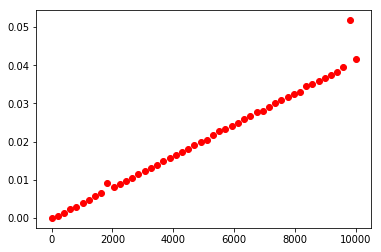

In [77]:
plt.plot(ns, ts, 'or');

Here's another function to time. This one takes a list instead of a number to process:

In [78]:
def demo2(lst):
    accum = 0
    for x in lst:
        accum += x
    return accum

We define our input sizes:

In [79]:
ns = np.linspace(1, 10_000, 50, dtype=int)

This time, for each invocation of `timeit` we need to build and pass a list of the appropriate size. Based on the line `accum += x` from the definition of `demo2`, it's clear that the elements in the list must support addition. We don't, however, want this line to be anything other than a constant-time operation (why?), so we'll just pass a list of integers. Order doesn't matter in this function, so we could trivially pass in `list(range(n))`, but in the example below we randomize the list just to demonstrate how to do so:

In [80]:
ts = [timeit.timeit('demo2(lst)', 
                    setup='lst = list(range({})) ; random.shuffle(lst)'.format(n),
                    number=100, 
                    globals=globals()) 
      for n in ns]

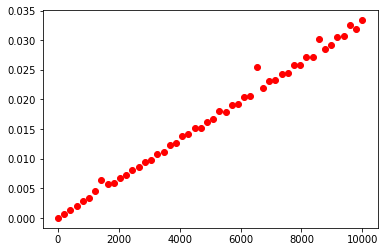

In [81]:
plt.plot(ns, ts, 'or');

## Plotting bounding functions

After collecting runtimes, the next step is to determine the worst-case asymptotic runtime complexity of our function, and, using that, to come up with and plot bounding functions. We will skip over the worst-case analysis and assume it is obvious that both `demo1` and `demo2` have linear worst-case runtime complexity. I.e., they are both $= O(N)$, where $N$ is the magnitude of the integer input to `demo1`, and the size of the list input to `demo2`. If we interpret this as a *tight* asymptotic bound, remember that this means we should be able to come up with multiplers $c_1$ and $c_2$ where for large $N$, $c_1N$ is smaller than the actual runtime and $c_2N$ is larger.

Let's look at the data collected. For `demo2`, we have the (partial) data points:

In [82]:
list(zip(ns, ts))[:10]

[(1, 1.3347715139389038e-05),
 (205, 0.0006668642163276672),
 (409, 0.001340717077255249),
 (613, 0.0020945481956005096),
 (817, 0.0029130857437849045),
 (1021, 0.0033141616731882095),
 (1225, 0.004472414031624794),
 (1429, 0.006489399820566177),
 (1633, 0.005670538172125816),
 (1837, 0.005959691479802132)]

We could use linear regression to come up with an equation for the best-fitting line, but we don't need anything so refined. Let's just compute the average of the slopes between all neighboring points:

In [83]:
sum = 0
for i in range(len(ns)-1):
    x0, x1 = ns[i:i+2]
    y0, y1 = ts[i:i+2]
    sum += (y1-y0) / (x1-x0) # recall: slope is (rise/run)
avg_slope = sum / (len(ns)-1)

It should make sense that for our bounding linear functions, we simply need to pick $c_1$ < slope, and $c_2$ > slope. To be safe, we use the multipliers 0.8 and 1.2 in our plot below (we also plot the line using the unaltered slope for good measure):

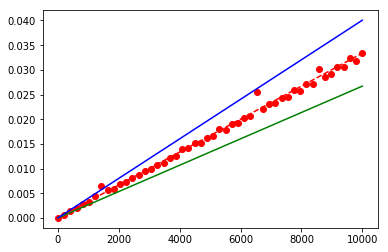

In [84]:
plt.plot(ns, ts, 'or')
plt.plot(ns, [avg_slope*n     for n in ns], '--r')
plt.plot(ns, [0.8*avg_slope*n for n in ns], '-g')   # green = lower bound
plt.plot(ns, [1.2*avg_slope*n for n in ns], '-b');  # blue = upper bound

While some early data points may lie outside the bounding functions, recall that the goal is to simply ensure all data points *after* some threshold value of $N$ lie within the bounding functions. 

You will need to state the worst-case asymptotic runtime complexity of, and produce a chart like this for all the functions below.

---

## Exercises

For the function provided in the first cell of each numbered exercise below, you will (1) state your hypothesized worst-case Big-O runtime complexity, (2) write code to collect timings for different sizes of input (it may take a bit of work to figure out how to come up with *worst-case* inputs!), and (3) plot the timings alongside bounding functions. As you work through an exercise, it's certainly possible that you may need to go back and revise your initial hypothesis. Note that the bounding functions must take the form $c \cdot g$, where $c$ is a constant multipler and $g$ is your stated runtime complexity. E.g., for a $O(N^2)$ function, your bounding functions will be of the form $c \cdot N^2$.

Each exercise already includes three cells beneath the provided function; simply fill them in with your own data. You are alotted a total of 30 seconds for all cells in the notebook to be evaluated, so you also need to be clever about collecting timings.

For each exercise, parts (1), (2), and (3) and worth 2 points each, giving a maximum score of 30 points for this lab.

## Exercise 1

In [85]:
def f1(lst):
    r = 0
    n = 100
    if len(lst) < n:
        n = len(lst)
    for x in range(n):
        r += x

Hypothesis: `f1` = O(n) 

In [86]:
# collect timing data into arrays/lists here
ns = []
ts = []
lst = [] 
for i in range(10000): 
    n = random.randint(1,150) 
    lst = random.sample(range(1,1000),n) 
    start = time.time() 
    f1(lst) 
    end = time.time() 
    ns.append(n) 
    ts.append(end-start)

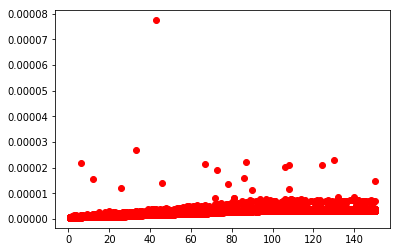

In [87]:
# plot your data and bounding functions here
plt.plot(ns, ts, 'or')
#plt.plot(ns, [], '-g')
#plt.plot(ns, [], '-b');
#Empty list are causing errors. It is impossible to plot those graphs. 

## Exercise 2

In [58]:
def f2(x):
    r = x / 2
    d = 1e-10
    while abs(x - r**2) > d:
        r = (r + x/r) / 2
    return r

Hypothesis: `f2` = O(1)

In [59]:
# collect timing data into arrays/lists here
ns = []
ts = []
for i in range(10000): 
    start = time.time()
    n = random.randint(1,150) 
    f2(n) 
    end = time.time() 
    ns.append(n) 
    ts.append(end-start)


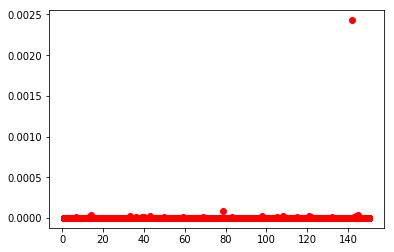

In [60]:
# plot your data and bounding functions here
plt.plot(ns, ts, 'or')
#plt.plot(ns, [], '-g')
#plt.plot(ns, [], '-b');
#Empty list are causing errors. It is impossible to plot those graphs. 

## Exercise 3

In [88]:
def f3(lst):
    while True:
        swapped = False
        for i in range(len(lst)-1):
            if lst[i] > lst[i+1]:
                lst[i], lst[i+1] = lst[i+1], lst[i]
                swapped = True
        if not swapped:
            break

Hypothesis: `f3` = O(𝑁^2)

In [89]:
# collect timing data into arrays/lists here
ns = []
ts = []
lst = [] 
for i in range(10000): 
    n = random.randint(1,150) 
    lst = random.sample(range(1,1000),n) 
    start = time.time() 
    f3(lst) 
    end = time.time() 
    ns.append(n) 
    ts.append(end-start)


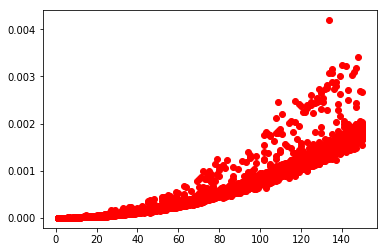

In [90]:
# plot your data and bounding functions here
plt.plot(ns, ts, 'or')
#plt.plot(ns, [], '-g')
#plt.plot(ns, [], '-b');
#Empty list are causing errors. It is impossible to plot those graphs. 

## Exercise 4

In [91]:
def f4(n):
    counters = [0] * n
    while not all(counters):
        for i in range(n):
            if counters[i]:
                counters[i] = 0
            else:
                counters[i] = 1
                break

Hypothesis: `f4` = O(?) &larr; fill in your hypothesis here

In [ ]:
# collect timing data into arrays/lists here
ns = []
ts = []
for i in range(10000): 
    start = time.time()
    n = random.randint(1,150) 
    f4(n) 
    end = time.time() 
    ns.append(n) 
    ts.append(end-start)


In [ ]:
# plot your data and bounding functions here
plt.plot(ns, ts, 'or')
#plt.plot(ns, [], '-g')
#plt.plot(ns, [], '-b');
#Empty list are causing errors. It is impossible to plot those graphs. 

## Exercise 5

In [207]:
def f5(lst):
    n = len(lst)
    for i in range(n*100):
        a = random.randrange(n)
        b = random.randrange(n)
        lst[a], lst[b] = lst[b], lst[a]

Hypothesis: `f5` = O(logN) 

In [208]:
# collect timing data into arrays/lists here
ns = []
ts = []
for i in range(10000): 
    n = random.randint(1,150) 
    lst = random.sample(range(1,1000),n) 
    start = time.time() 
    f5(lst) 
    end = time.time() 
    ns.append(n) 
    ts.append(end-start)

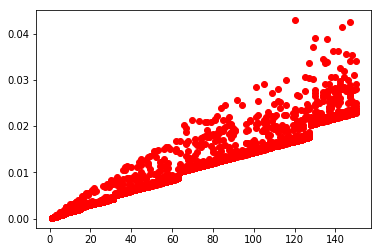

In [209]:
# plot your data and bounding functions here
plt.plot(ns, ts, 'or')
#plt.plot(ns, [], '-g')
#plt.plot(ns, [], '-b');
#Empty list are causing errors. It is impossible to plot those graphs. 